<a href="https://colab.research.google.com/github/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/Cuaderno_1_Grupo5_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion
Para girar la imagen utilizaremos conocimientos basicos de algebra, especificamente utilizaremos la siguiente matriz de transformacion...

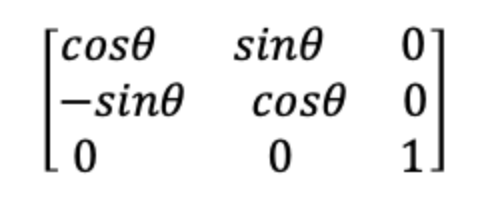

Donde θ es el angulo que se rotara la imagen.
Para lograr el resultado deseado a cada pixel de la imagen original se le asignara una nueva ubicacion (x , y) deifnida por la matriz ya mostrada. 

In [ ]:

#@title ## Armado del ambiente
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true" #@param {type:"string"}
#@markdown ---
#@markdown ### Los grados que desea girar la imagen:
degrees = '45' #@param {type:"string"}
#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg
!pip install pycuda

--2021-11-22 21:23:17--  https://github.com/SisopTeam3-SoaTeam5/TP2/blob/main/HPC/images/apple--600.png?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SisopTeam3-SoaTeam5/TP2/raw/main/HPC/images/apple--600.png [following]
--2021-11-22 21:23:17--  https://github.com/SisopTeam3-SoaTeam5/TP2/raw/main/HPC/images/apple--600.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SisopTeam3-SoaTeam5/TP2/main/HPC/images/apple--600.png [following]
--2021-11-22 21:23:18--  https://raw.githubusercontent.com/SisopTeam3-SoaTeam5/TP2/main/HPC/images/apple--600.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

Con CPU

Tiempo de conversión de imagen: 1022.372 [ms]
Tiempo Total: 1075.819 [ms]


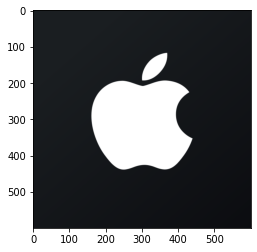

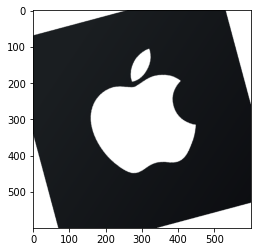

In [ ]:
 try:
  %matplotlib inline
  from datetime import datetime

  tiempo_total = datetime.now()

  import  matplotlib.pyplot as plt
  import numpy 
  from PIL import Image
  import math

  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  #Convert degrees to radians
  angle = numpy.deg2rad(int(degrees))

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre )

  img_ancho, img_alto = image.width,image.height

  img_pic_cpu = numpy.asarray(image)
  img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
  img_picR_cpu = numpy.empty_like( img_pic_cpu)    



  plt.figure()
  imgplot=plt.imshow( img_pic_cpu )


  center_hor=img_ancho/2
  center_vert=img_alto/2

  coseno=math.cos(angle)
  seno=math.sin(angle)

  tiempo_img = datetime.now()

  for y  in range( 0, img_alto ):
    for x in range( 0, img_ancho ):
      xb = int(round(coseno*(x-center_vert) - seno*(y-center_hor) + center_hor))
      yb = int(round(coseno*(y-center_hor) + seno*(x-center_vert) + center_vert))
      if(xb>=0 and yb>=0 and xb<img_ancho and yb<img_alto):
        img_picR_cpu[y][x] = img_pic_cpu[yb][xb]
      else:
        img_picR_cpu[y][x]=255

  tiempo_img = datetime.now() - tiempo_img

  plt.figure()
  imgplot = plt.imshow( img_picR_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
  print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )
except NameError:
  print("Debe ejecutar las secciones de código anteriores antes de esta")
except:
  print("Ha ocurrido un error durante la ejecución")

Usando GPU

Tiempo TOTAL:  50.6 [ms]
Tiempo GPU  :  0.216 [ms]


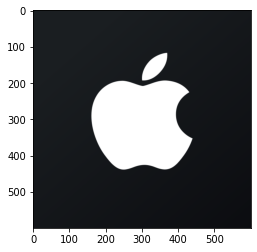

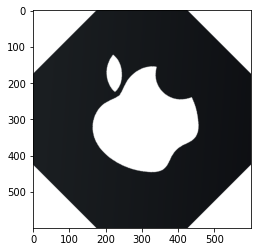

In [ ]:
try:
  %matplotlib inline
  from datetime import datetime

  tiempo_total_gpu = datetime.now()

  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  import math

  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  #Convert degrees to radians
  angle = numpy.deg2rad(int(degrees))

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre )

  img_ancho, img_alto = image.width,image.height
  #Convert image in array
  img_pic_cpu = numpy.asarray(image)
  img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
  img_picR_cpu = numpy.empty_like( img_pic_cpu)    

  #Pass arrays to GPU
  img_pic_gpu = cuda.mem_alloc( img_pic_cpu.nbytes )
  img_picR_gpu = cuda.mem_alloc( img_picR_cpu.nbytes )
  cuda.memcpy_htod( img_pic_gpu, img_pic_cpu )
  cuda.memcpy_htod( img_picR_gpu, img_picR_cpu )

  center_hor=img_ancho/2
  center_vert=img_alto/2

  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, int center_hor,int center_vert,float seno, float coseno , int *img_O, int *img_R )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      int xb = int(coseno*(idx-center_vert) - (seno)*(idy-center_hor) + center_hor);
      int yb = int(coseno*(idy-center_hor) + (seno)*(idx-center_vert) + center_vert);
      if(xb>=0 and yb>=0 and xb<ancho and yb<alto){
        img_R[(idx+(idy*ancho))*3] = img_O[(xb+(yb*ancho))*3];
        img_R[(idx+(idy*ancho))*3 + 1] = img_O[(xb+(yb*ancho))*3 +1];
        img_R[(idx+(idy*ancho))*3 + 2] = img_O[(xb+(yb*ancho))*3 +2];
      }
      else{
        img_R[(idx+(idy*ancho))*3]=255;
        img_R[(idx+(idy*ancho))*3 +1]=255;
        img_R[(idx+(idy*ancho))*3 +2]=255;
      }
    }
  }
  """) 
  kernel = module.get_function("kernel_img")



  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  coseno=math.cos(angle)
  seno=math.sin(angle)

  tiempo_img_gpu = datetime.now()

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_img_gpu = datetime.now() - tiempo_img_gpu

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_picR_cpu, img_picR_gpu )

  # Muestro la imagen Original
  plt.figure()
  imgplot=plt.imshow( img_pic_cpu )

  # Muestro la imagen luego
  plt.figure()
  imgplot=plt.imshow( img_picR_cpu )

  tiempo_total_gpu = datetime.now() - tiempo_total_gpu

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_gpu ), "[ms]" )
except ModuleNotFoundError:
  print("Falta instalar dependencias. Ejecute las secciones de código anteriores antes de ejecutar esa parte")
except:
  print("Ha ocurrido un error en la ejecución")



In [ ]:
err=0
try:
  if tiempo_total!=None and tiempo_total_gpu!=None:
    err=0
except:
  err=1
if err==0:
  print('------------------------------------------')
  print('-           Seccion de metricas          -')
  print('------------------------------------------')
  print('| Metrica     |     CPU     |     GPU    |')
  print('|-------------|-------------|------------|')
  print('|Tiempo total |' , tiempo_en_ms( tiempo_total), "ms",'|', tiempo_en_ms(tiempo_total_gpu), 'ms', ' |')
  print('|-------------|-------------|------------|')
  print('|Tiempo imagen|' , tiempo_en_ms( tiempo_img), "ms",'|', tiempo_en_ms(tiempo_img_gpu), 'ms', '  |')
  print('------------------------------------------')
else:
  print("Debe ejecutar las secciones anteriores de código antes de esta")


------------------------------------------
-           Seccion de metricas          -
------------------------------------------
| Metrica     |     CPU     |     GPU    |
|-------------|-------------|------------|
|Tiempo total | 1116.606 ms | 58.152 ms  |
|-------------|-------------|------------|
|Tiempo imagen| 1062.34 ms | 0.104 ms   |
------------------------------------------


## Preguntas punto 4

a) Al planificar la mitad de los hilos no se alcanza a cubrir todos los píxeles de la imagen, ya que cada hilo se encarga de un pixel. Por lo tanto el resultado no es el deseado.

b) Al planificar el doble, el resultado final coincide con el esperado. Habrá muchos hilos de mas que acabarán luego de comprobar si los índices están bajo los límites de la imagen.
En ambos casos no se aprecia diferencia en los tiempos de ejecución de la GPU, porque al ejecutar los hilos de forma concurrente en distintos nucleos, la cantidad no es significativa en este aspecto.

e) Si se planificara la máxima cantidad posible de hilos el resultado sería como cuando se planifica el doble. Habrán nucleos que al ejecutar saldrán en la primera comrpobación, y el resto transformarán la imagen.

Imagen original - 1ra imagen

Imagen con mitad de hilos - 2da imagen. Tiempos:
Tiempo GPU  :  0.1 [ms]

Imagen con doble de hilos - 3ra imagen. Tiempos:
Tiempo GPU  :  0.034 [ms]


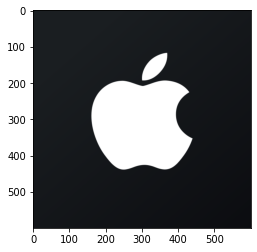

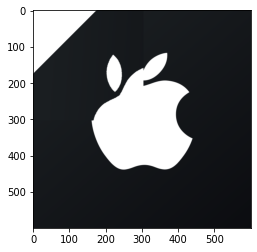

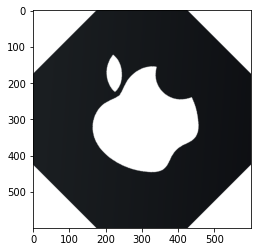

In [ ]:
try:
  %matplotlib inline
  from datetime import datetime

  tiempo_total_gpu = datetime.now()

  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  import math

  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  #Convert degrees to radians
  angle = numpy.deg2rad(int(degrees))

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre )

  img_ancho, img_alto = image.width,image.height
  #Convert image in array
  img_pic_cpu = numpy.asarray(image)
  img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
  img_picR_cpu_mitad = numpy.empty_like( img_pic_cpu)    
  img_picR_cpu_doble = numpy.empty_like( img_pic_cpu)    

  #Pass arrays to GPU
  img_pic_gpu = cuda.mem_alloc( img_pic_cpu.nbytes )
  img_picR_gpu_mitad = cuda.mem_alloc( img_picR_cpu.nbytes )
  img_picR_gpu_doble = cuda.mem_alloc( img_picR_cpu.nbytes )
  cuda.memcpy_htod( img_pic_gpu, img_pic_cpu )
  cuda.memcpy_htod( img_picR_gpu_mitad, img_picR_cpu_mitad )
  cuda.memcpy_htod( img_picR_gpu_doble, img_picR_cpu_doble )

  center_hor=img_ancho/2
  center_vert=img_alto/2
  kernel = module.get_function("kernel_img")



  dim_hilo_x = 16
  dim_hilo_y = 19
  dim_bloque_x_mitad = numpy.int( ((img_ancho+dim_hilo_x-1) / dim_hilo_x) /2) 
  dim_bloque_y_mitad = numpy.int( ((img_alto+dim_hilo_y-1) / dim_hilo_y )/ 2) 
  dim_bloque_x_doble = numpy.int( ((img_ancho+dim_hilo_x-1) / dim_hilo_x) *2) 
  dim_bloque_y_doble = numpy.int( ((img_alto+dim_hilo_y-1) / dim_hilo_y ) *2) 

  coseno=math.cos(angle)
  seno=math.sin(angle)

  tiempo_img_gpu_mitad = datetime.now()
  kernel( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu_mitad, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x_mitad, dim_bloque_y_mitad,1) )
  tiempo_img_gpu_mitad = datetime.now() - tiempo_img_gpu_mitad
  tiempo_img_gpu_doble = datetime.now()
  kernel( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu_doble, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x_doble, dim_bloque_y_doble,1) )
  tiempo_img_gpu_doble = datetime.now() - tiempo_img_gpu_doble


  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_picR_cpu_mitad, img_picR_gpu_mitad )
  cuda.memcpy_dtoh( img_picR_cpu_doble, img_picR_gpu_doble )

  print("Imagen original - 1ra imagen")
  print("\nImagen con mitad de hilos - 2da imagen. Tiempos:")
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_gpu_mitad ), "[ms]" )
  print("\nImagen con doble de hilos - 3ra imagen. Tiempos:")
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_gpu_doble ), "[ms]" )
  plt.figure()
  imgplot=plt.imshow( img_pic_cpu )

  # Muestro la imagen luego
  plt.figure()
  imgplot=plt.imshow( img_picR_cpu_mitad )
  plt.figure()
  imgplot=plt.imshow( img_picR_cpu_doble )

except ModuleNotFoundError:
  print("Falta instalar dependencias. Ejecute las secciones de código anteriores antes de ejecutar esa parte")
except:
  print("Ha ocurrido un error en la ejecución, asegúrese de ejecutar las seciones anteriores")


Para procesar la mitad superior de la imagen se debe cambiar la validación de los índices, y en lugar de preguntar si idy es menor al alto, preguntar si es menor a la mitad del alto.
Para procesar la mitad inferior, se debería preguntar si está entre el valor medio y final, es decir, si idy es mayor o igual a la mitad del alto y menor al alto total.

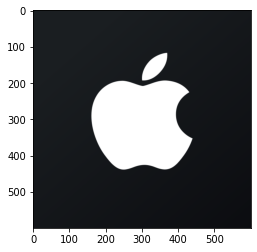

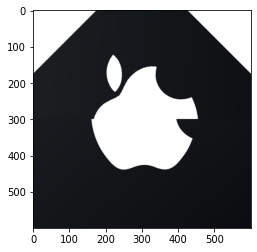

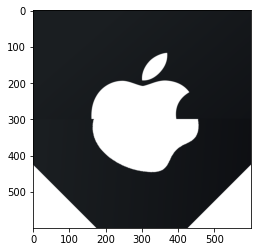

In [ ]:
try:
  %matplotlib inline
  from datetime import datetime

  tiempo_total_gpu = datetime.now()

  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  import math

  #Convert degrees to radians
  angle = numpy.deg2rad(int(degrees))

  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre )

  img_ancho, img_alto = image.width,image.height
  #Convert image in array
  img_pic_cpu = numpy.asarray(image)
  img_pic_cpu = img_pic_cpu.astype( numpy.int32() )
  img_picR_cpu = numpy.empty_like( img_pic_cpu)    

  #Pass arrays to GPU
  img_pic_gpu = cuda.mem_alloc( img_pic_cpu.nbytes )
  img_picR_gpu = cuda.mem_alloc( img_picR_cpu.nbytes )
  cuda.memcpy_htod( img_pic_gpu, img_pic_cpu )
  cuda.memcpy_htod( img_picR_gpu, img_picR_cpu )

  center_hor=img_ancho/2
  center_vert=img_alto/2

  module = SourceModule("""
  __global__ void kernel_img_sup( int ancho, int alto, int center_hor,int center_vert,float seno, float coseno , int *img_O, int *img_R )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto/2 )
    {
      int xb = int(coseno*(idx-center_vert) - (seno)*(idy-center_hor) + center_hor);
      int yb = int(coseno*(idy-center_hor) + (seno)*(idx-center_vert) + center_vert);
      if(xb>=0 and yb>=0 and xb<ancho and yb<alto){
        img_R[(idx+(idy*ancho))*3] = img_O[(xb+(yb*ancho))*3];
        img_R[(idx+(idy*ancho))*3 + 1] = img_O[(xb+(yb*ancho))*3 +1];
        img_R[(idx+(idy*ancho))*3 + 2] = img_O[(xb+(yb*ancho))*3 +2];
      }
      else{
        img_R[(idx+(idy*ancho))*3]=255;
        img_R[(idx+(idy*ancho))*3 +1]=255;
        img_R[(idx+(idy*ancho))*3 +2]=255;
      }
    }
    else if(idx < ancho && idy < alto){
      img_R[(idx+(idy*ancho))*3] = img_O[(idx+(idy*ancho))*3];
      img_R[(idx+(idy*ancho))*3 + 1] = img_O[(idx+(idy*ancho))*3 + 1];
      img_R[(idx+(idy*ancho))*3 + 2] = img_O[(idx+(idy*ancho))*3 + 2];
    }
  }

  __global__ void kernel_img_inf( int ancho, int alto, int center_hor,int center_vert,float seno, float coseno , int *img_O, int *img_R )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy >= alto/2 && idy < alto)
    {
      int xb = int(coseno*(idx-center_vert) - (seno)*(idy-center_hor) + center_hor);
      int yb = int(coseno*(idy-center_hor) + (seno)*(idx-center_vert) + center_vert);
      if(xb>=0 and yb>=0 and xb<ancho and yb<alto){
        img_R[(idx+(idy*ancho))*3] = img_O[(xb+(yb*ancho))*3];
        img_R[(idx+(idy*ancho))*3 + 1] = img_O[(xb+(yb*ancho))*3 +1];
        img_R[(idx+(idy*ancho))*3 + 2] = img_O[(xb+(yb*ancho))*3 +2];
      }
      else{
        img_R[(idx+(idy*ancho))*3]=255;
        img_R[(idx+(idy*ancho))*3 +1]=255;
        img_R[(idx+(idy*ancho))*3 +2]=255;
      }
    }
    else if(idx < ancho && idy < alto){
      img_R[(idx+(idy*ancho))*3] = img_O[(idx+(idy*ancho))*3];
      img_R[(idx+(idy*ancho))*3 + 1] = img_O[(idx+(idy*ancho))*3 + 1];
      img_R[(idx+(idy*ancho))*3 + 2] = img_O[(idx+(idy*ancho))*3 + 2];
    }
  }
  """) 
  
  kernel_inf = module.get_function("kernel_img_inf")
  kernel_sup = module.get_function("kernel_img_sup")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  coseno=math.cos(angle)
  seno=math.sin(angle)

  kernel_sup( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  cuda.memcpy_dtoh( img_picR_cpu, img_picR_gpu )
  plt.figure()
  imgplot=plt.imshow( img_pic_cpu )

  plt.figure()
  imgplot=plt.imshow( img_picR_cpu )

  kernel_inf( numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(center_hor),numpy.int32(center_vert),numpy.float32(seno),numpy.float32(coseno), img_pic_gpu, img_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
  cuda.memcpy_dtoh( img_picR_cpu, img_picR_gpu )
  plt.figure()
  imgplot=plt.imshow( img_picR_cpu )
  
except ModuleNotFoundError:
  print("Falta instalar dependencias. Ejecute las secciones de código anteriores antes de ejecutar esa parte")
except:
  print("Ha ocurrido un error en la ejecución")



# Colclusiones 
Dado a las metricas obtenidas podemos afirmar sin duda que la implementacion de gpu es muchisimo mas rapido que la del cpu, esto dado al parelelismo que el gpu nos brinda. La ejecucion general llega a ser de entre 17 y 18 veces mas rapido. Y solamente el procesamiento de la imagen pixel por pixel llega a ser 2500 veces mas rapido. Claramente se nota el beneficio de utilizar el paralelismo que nos brinda la gpu.

# Bibliografia


1. 	pythontic.com, “Rotate An Image Using Python Image Processing Library - Pillow”, Disponible en: https://pythontic.com/image-processing/pillow/rotate [Accedido: 19/11/2021]

2.	Nvidia developer zone, “Single Precision Mathematical Functions”, Disponible en: https://docs.nvidia.com/cuda/cuda-math-api/group__CUDA__MATH__SINGLE.html [Accedido: 19/11/2021]

3.	Waldo Valiente, “Prueba 2 - Imagen - GPU”, 					
  Disponible en: https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb [Accedido: 18/11/2021]
